In [8]:
# Importer les bibliothèques nécessaires
import cv2
import numpy as np
from numba import njit, jit
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time as t
from skimage import io
import imageio
import sys

In [40]:
@njit
def ZSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)
    patch1_normalized = patch1 - mean1
    patch2_normalized = patch2 - mean2
    zssd_score = np.square(patch1_normalized - patch2_normalized).sum()
    return zssd_score

@njit
def njint_roll(a, dy):
    out = np.empty(a.shape, np.int32)
    for i in range(a.shape[0]):
        out[i] = np.roll(a[i], dy)
    return out

@njit
def sgm(left_image, right_image, P1, P2, num_disparities, block_size):
    height, width = left_image.shape

    disparities = np.zeros((height, width), dtype=np.uint8)
    costs = np.zeros((height, width, num_disparities), dtype=np.int32)
    min_costs = np.zeros((height, width, num_disparities), dtype=np.int32)

    # Initialize costs
    for d in range(num_disparities):
        shifted = njint_roll(right_image, d)
        costs[:, :, d] = np.abs(left_image - shifted)

    # Compute minimum costs using multiple directions
    directions = [(0, 1), (-1, 0), (0, -1), (1, 0)]  # Right, Up, Left, Down
    for d in range(num_disparities):
        for y in range(height):
            for x in range(width):
                min_cost = costs[y, x, d]
                for direction in directions:
                    dx, dy = direction
                    if 0 <= x + dx < width and 0 <= y + dy < height:
                        min_cost = min(min_cost, min_costs[y + dy, x + dx, d] + P1)
                for i in range(1, num_disparities):
                    if d - i >= 0:
                        min_cost = min(min_cost, min_costs[y, x, d - i] + P2)
                    if d + i < num_disparities:
                        min_cost = min(min_cost, min_costs[y, x, d + i] + P2)
                min_costs[y, x, d] = min_cost

    # Find disparity with minimum accumulated cost
    for y in range(height):
        for x in range(width):
            disparities[y, x] = np.argmin(min_costs[y, x])

    return disparities

@njit
def mode_filter(img, N=5):
    h, w = img.shape
    filtered_img = np.zeros_like(img)

    margin = N//2
    # Parcourir chaque pixel de la carte de disparités
    for i in range(h):
        for j in range(w):
            # Extraire la fenêtre 5x5 centrée sur le pixel actuel
            block = img[max(0, i - margin):min(h, i + margin+1), max(0, j - margin):min(w, j + margin+1)]

            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k

    return filtered_img


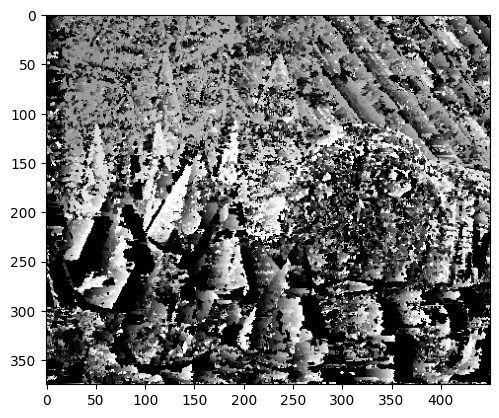

In [41]:
Iref = cv2.imread("cones/im2.png", cv2.IMREAD_GRAYSCALE)
Isearch = cv2.imread("cones/im6.png", cv2.IMREAD_GRAYSCALE)

P1 = 10
P2 = 20
num_disparities = 32
block_size = 7

disp = sgm(Iref, Isearch, P1, P2, num_disparities, block_size)
disp = mode_filter(disp, 3)
plt.imshow(disp, cmap="gray")

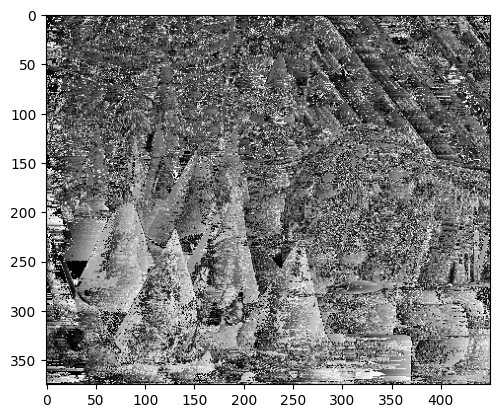

In [27]:
plt.imshow(disp, cmap="gray")

In [162]:
import argparse
import sys
import time as t

import cv2
import numpy as np
from numba import njit

"""
Parameters :
P1 = 10
P2 = 20
num_disparities = 32
block_size = 7
"""

def compute_census(left, right, kernel):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - kernel: kernel size for the census transform.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    y_offset = kernel // 2
    x_offset = kernel // 2
    height, width = left.shape

    left_census = np.zeros_like(left, dtype=np.uint64)
    right_census = np.zeros_like(left, dtype=np.uint64)

    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            apex = left[y, x]
            ref = np.full(shape=(kernel, kernel), fill_value=apex, dtype=np.int32)
            image = left[
                y - y_offset : y + y_offset + 1, x - x_offset : x + x_offset + 1
            ]
            diff = image - ref
            # If value is less than center value assign 1 otherwise assign 0
            left_mask_arr = np.where(diff < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_mask = np.int32(
                left_mask_arr.dot(1 << np.arange(kernel * kernel)[::-1])
            )
            left_census[y, x] = left_mask

            apex = right[y, x]
            ref = np.full(shape=(kernel, kernel), fill_value=apex, dtype=np.int32)
            image = right[
                y - y_offset : y + y_offset + 1, x - x_offset : x + x_offset + 1
            ]
            diff = image - ref
            # If value is less than center value assign 1 otherwise assign 0
            right_mask_arr = np.where(diff < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_mask = np.int32(
                right_mask_arr.dot(1 << np.arange(kernel * kernel)[::-1])
            )
            right_census[y, x] = right_mask

    return left_census, right_census


def compute_costs(left, right, csize, maxdisp):
    """
    Computes the matching cost volume between two stereo images.
    Args:
        left (ndarray): Left image (ndarray format).
        right (ndarray): Right image (ndarray format).
        csize (int): Window size for Census computation.
        maxdisp (int): Maximum disparity value.

    Returns:
        ndarray: Left cost volume (shape: [height, width, maxdisp]).
    """

    height = left.shape[0]
    width = left.shape[1]
    y_offset = int(csize / 2)
    x_offset = int(csize / 2)

    left_cost_volume = np.zeros(shape=(height, width, maxdisp), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, maxdisp), dtype=np.uint32)
    rcensus = np.zeros(shape=(height, width), dtype=np.int64)
    for d in range(0, maxdisp):
        rcensus[:, (x_offset + d):(width - x_offset)] = right[:, x_offset:(width - d - x_offset)]
        left_xor = np.int64(np.bitwise_xor(np.int64(left), rcensus))
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        left_cost_volume[:, :, d] = left_distance

    return left_cost_volume


def get_path_cost(slice, offset, P1, P2):
    """
    part of the aggregation step, finds the minimum costs in a D x M slice (where M = the number of pixels in the
    given direction)
    :param slice: M x D array from the cost volume.
    :param offset: ignore the pixels on the border.
    :param parameters: structure containing parameters of the algorithm.
    :return: M x D array of the minimum costs for a given slice in a given direction.
    """
    other_dim = slice.shape[0]
    disparity_dim = slice.shape[1]

    disparities = [d for d in range(disparity_dim)] * disparity_dim
    disparities = np.array(disparities).reshape(disparity_dim, disparity_dim)

    penalties = np.zeros(shape=(disparity_dim, disparity_dim), dtype=slice.dtype)
    penalties[np.abs(disparities - disparities.T) == 1] = P1
    penalties[np.abs(disparities - disparities.T) > 1] = P2

    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=slice.dtype)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for i in range(offset, other_dim):
        previous_cost = minimum_cost_path[i - 1, :]
        current_cost = slice[i, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        costs = np.amin(costs + penalties, axis=0)
        minimum_cost_path[i, :] = current_cost + costs - np.amin(previous_cost)
    return minimum_cost_path

def get_indices(offset, dim, direction, height):
    """
    for the diagonal directions (SE, SW, NW, NE), return the array of indices for the current slice.
    :param offset: difference with the main diagonal of the cost volume.
    :param dim: number of elements along the path.
    :param direction: current aggregation direction.
    :param height: H of the cost volume.
    :return: arrays for the y (H dimension) and x (W dimension) indices.
    """
    y_indices = []
    x_indices = []

    for i in range(0, dim):
        if direction == (1, 1):
            if offset < 0:
                y_indices.append(-offset + i)
                x_indices.append(0 + i)
            else:
                y_indices.append(0 + i)
                x_indices.append(offset + i)

        if direction == (-1, 1):
            if offset < 0:
                y_indices.append(height + offset - i)
                x_indices.append(0 + i)
            else:
                y_indices.append(height - i)
                x_indices.append(offset + i)

    return np.array(y_indices), np.array(x_indices)

def aggregate_costs(cost_volume, P1, P2):
    """
    second step of the sgm algorithm, aggregates matching costs for N possible directions (8 in this case).
    :param cost_volume: array containing the matching costs.
    :param parameters: structure containing parameters of the algorithm.
    :param paths: structure containing all directions in which to aggregate costs.
    :return: H x W x D x N array of matching cost for all defined directions.
    """
    height = cost_volume.shape[0]
    width = cost_volume.shape[1]
    disparities = cost_volume.shape[2]
    start = -(height - 1)
    end = width - 1
    
    directions = [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)]
    effective_directions = [((1, 0),  (-1, 0)), ((1, 1), (-1, -1)), ((0, 1), (0, -1)), ((-1, 1), (1, -1))]

    aggregation_volume = np.zeros(shape=(height, width, disparities, len(directions)), dtype=cost_volume.dtype)

    path_id = 0
    for direction in effective_directions:
        main_aggregation = np.zeros(shape=(height, width, disparities), dtype=cost_volume.dtype)
        opposite_aggregation = np.copy(main_aggregation)
        
        if direction[0] == (0, 1):
            for x in range(0, width):
                south = cost_volume[0:height, x, :]
                north = np.flip(south, axis=0)
                main_aggregation[:, x, :] = get_path_cost(south, 1, P1, P2)
                opposite_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, P1, P2), axis=0)
                
        if direction[0] == (1,0):
            for y in range(0, height):
                east = cost_volume[y, 0:width, :]
                west = np.flip(east, axis=0)
                main_aggregation[y, :, :] = get_path_cost(east, 1, P1, P2)
                opposite_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, P1, P2), axis=0)
            
        if direction[0] == (1,1):
            for offset in range(start, end):
                south_east = cost_volume.diagonal(offset=offset).T
                north_west = np.flip(south_east, axis=0)
                dim = south_east.shape[0]
                y_se_idx, x_se_idx = get_indices(offset, dim, (1,1), None)
                y_nw_idx = np.flip(y_se_idx, axis=0)
                x_nw_idx = np.flip(x_se_idx, axis=0)
                main_aggregation[y_se_idx, x_se_idx, :] = get_path_cost(south_east, 1, P1, P2)
                opposite_aggregation[y_nw_idx, x_nw_idx, :] = get_path_cost(north_west, 1, P1, P2)
        
        if direction[0] == (-1, 1):
            for offset in range(start, end):
                south_west = np.flipud(cost_volume).diagonal(offset=offset).T
                north_east = np.flip(south_west, axis=0)
                dim = south_west.shape[0]
                y_sw_idx, x_sw_idx = get_indices(offset, dim, (-1, 1), height - 1)
                y_ne_idx = np.flip(y_sw_idx, axis=0)
                x_ne_idx = np.flip(x_sw_idx, axis=0)
                main_aggregation[y_sw_idx, x_sw_idx, :] = get_path_cost(south_west, 1, P1, P2)
                opposite_aggregation[y_ne_idx, x_ne_idx, :] = get_path_cost(north_east, 1, P1, P2)
    
        aggregation_volume[:, :, :, path_id] = main_aggregation
        aggregation_volume[:, :, :, path_id + 1] = opposite_aggregation
        path_id = path_id + 2

    return aggregation_volume

def select_disparity(aggregation_volume):
    """
    last step of the sgm algorithm, corresponding to equation 14 followed by winner-takes-all approach.
    :param aggregation_volume: H x W x D x N array of matching cost for all defined directions.
    :return: disparity image.
    """
    volume = np.sum(aggregation_volume, axis=3)
    disparity_map = np.argmin(volume, axis=2)
    return disparity_map


@njit
def mode_filter(img, N=5):
    h, w = img.shape
    filtered_img = np.zeros_like(img)

    margin = N//2
    # Parcourir chaque pixel de la carte de disparités
    for i in range(h):
        for j in range(w):
            # Extraire la fenêtre 5x5 centrée sur le pixel actuel
            block = img[max(0, i - margin):min(h, i + margin+1), max(0, j - margin):min(w, j + margin+1)]

            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k

    return filtered_img

def normalize(disp, max_disparity):
    return 255.0 * disp / max_disparity


In [126]:
Iref = cv2.imread("cones/im2.png", cv2.IMREAD_GRAYSCALE)
Isearch = cv2.imread("cones/im6.png", cv2.IMREAD_GRAYSCALE)

P1 = 10
P2 = 120
maxdisp = 64
block_size = 7
csize = 3
ksize = (3,3)

directions = [(0, 1), (-1, 0), (0, -1), (1, 0)]  # Right, Up, Left, Down

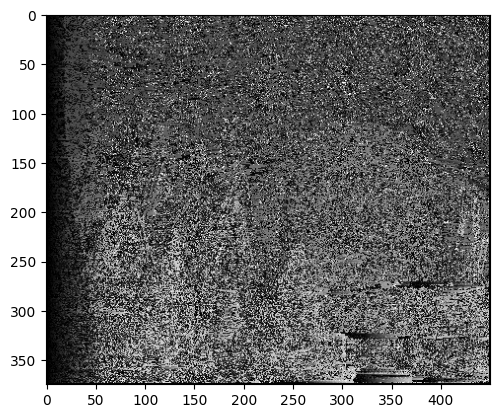

In [153]:
# Preprocessing
left_census, right_census = compute_census(Iref, Isearch, csize)

left_cost_volume = compute_costs(left_census, right_census, csize, maxdisp)
plt.imshow(np.argmin(left_cost_volume, axis=2), cmap="gray")

In [156]:
left_aggregation_volume = aggregate_costs(left_cost_volume, P1, P2)

shape (375, 450, 64, 8)
(375, 450, 64)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function add>) found for signature:
 
 >>> add(none, int64)
 
There are 20 candidate implementations:
[1m   - Of which 18 did not match due to:
   Overload of function 'add': File: <numerous>: Line N/A.
     With argument(s): '(none, int64)':[0m
[1m    No match.[0m
[1m   - Of which 2 did not match due to:
   Operator Overload in function 'add': File: unknown: Line unknown.
     With argument(s): '(none, int64)':[0m
[1m    No match for registered cases:
     * (int64, int64) -> int64
     * (int64, uint64) -> int64
     * (uint64, int64) -> int64
     * (uint64, uint64) -> uint64
     * (float32, float32) -> float32
     * (float64, float64) -> float64
     * (complex64, complex64) -> complex64
     * (complex128, complex128) -> complex128[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /tmp/ipykernel_28630/364695911.py (157)[0m
[1m
File "../../../tmp/ipykernel_28630/364695911.py", line 157:[0m
[1m<source missing, REPL/exec in use?>[0m


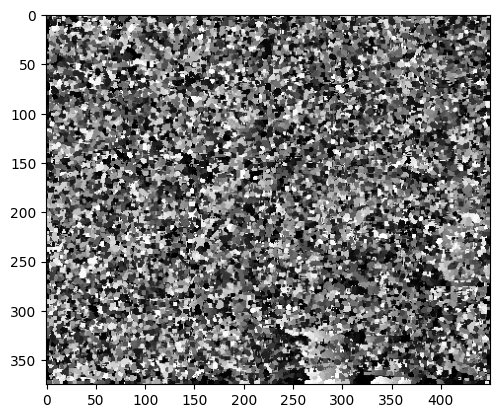

In [148]:
left_disparity_map = select_disparity(left_aggregation_volume)
left_disparity_map = mode_filter(left_disparity_map, 5)
plt.imshow(left_disparity_map, cmap="gray")
sauv_left_disp = left_disparity_map

In [144]:
left_disparity_map = sauv_left_disp
cv2.imwrite('test1.png', normalize(left_disparity_map, maxdisp))

True

In [228]:
from evaldisp import evaldisp

P1 = 0
P2 = 4
maxdisp = 64
block_size = 7
csize = 3
msize = 5

gt = cv2.imread("cones/disp2.png", cv2.IMREAD_GRAYSCALE)
occl = cv2.imread("cones/occl.png", cv2.IMREAD_GRAYSCALE)
res = []

#left_census, right_census = compute_census(Iref, Isearch, csize)
#left_cost_volume = compute_costs(left_census, right_census, csize, maxdisp)

for i in range(1, 10, 1):
    print(i)
    P2 = i
    left_aggregation_volume = aggregate_costs(left_cost_volume, P1, P2)
    left_disparity_map = select_disparity(left_aggregation_volume)
    left_disparity_map = mode_filter(left_disparity_map, msize)
    left_disparity_map = normalize(left_disparity_map, maxdisp)
    err_moy, ps1, ps2 = evaldisp(gt, occl, left_disparity_map)
    res.append((i, err_moy, ps1, ps2))

1
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
2
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
3
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
4
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
5
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
6
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
7
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
8
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
9
shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)


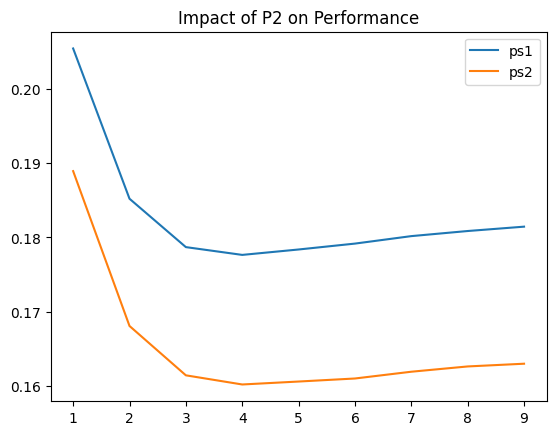

In [231]:
res = np.array(res)
### Create the plot
#plt.plot(res[:,0], res[:,1], label='pixel accuracy')
plt.plot(res[:,0], res[:,2], label='ps1')
plt.plot(res[:,0], res[:,3], label='ps2')

plt.title('Impact of P2 on Performance')
plt.legend()
plt.savefig("SGM/ps1_ps2_P2_3.png")

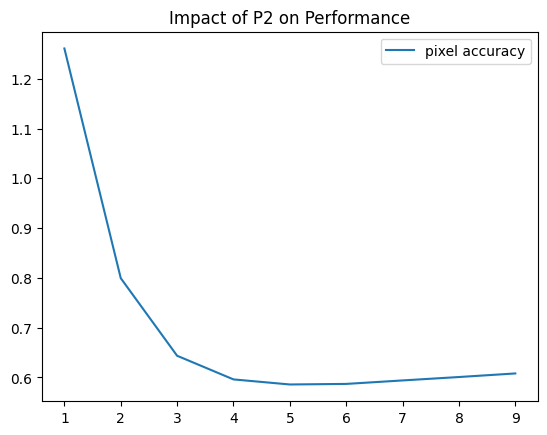

In [232]:
### Create the plot
plt.plot(res[:,0], res[:,1], label='pixel accuracy')
plt.title('Impact of P2 on Performance')
plt.legend()
plt.savefig("SGM/acc_P2_3.png")

In [234]:
from evaldisp import evaldisp
import time

P1 = 0
P2 = 4
maxdisp = 64
block_size = 7
csize = 3
ksize = (3,3)
msize = 9

Iref = cv2.imread("cones/im2.png", cv2.IMREAD_GRAYSCALE)
Isearch = cv2.imread("cones/im6.png", cv2.IMREAD_GRAYSCALE)


gt = cv2.imread("cones/disp2.png", cv2.IMREAD_GRAYSCALE)
occl = cv2.imread("cones/occl.png", cv2.IMREAD_GRAYSCALE)
res = []
start = time.time()
left_census, right_census = compute_census(Iref, Isearch, csize)
left_cost_volume = compute_costs(left_census, right_census, csize, maxdisp)

left_aggregation_volume = aggregate_costs(left_cost_volume, P1, P2)
left_disparity_map = select_disparity(left_aggregation_volume)
left_disparity_map = mode_filter(left_disparity_map, msize)
left_disparity_map = normalize(left_disparity_map, maxdisp)

print('\t(done in {:.2f}s)'.format(time.time() - start), evaldisp(gt, occl, left_disparity_map))

cv2.imwrite('test_cones.png', left_disparity_map)

shape (375, 450, 64, 8)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
(375, 450, 64)
	(done in 56.28s) (0.5715718005693898, 0.16628148148148147, 0.15762962962962962)


True